# CNN

In [98]:
import time

import torch
import torch.nn as nn
from torch.autograd import Variable

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np

import os, sys

import utils

from train import train

from best_utils import *
from cross_validation import cross_validation
import image_preprocessing

from skimage import color

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [99]:
ROOT_DIR = 'training/'
IMAGE_DIR = ROOT_DIR + 'images/'

PATCH_SIZE = 5

N = 5 # Number of image to be used in training

In [100]:
KERNEL_SIZE = 3
KERNEL_RADIUS = (KERNEL_SIZE - 1) // 2

In [101]:
# Using kernels of size 5, 3, 3, 3 => radii = 2, 1, 1, 1 => padding radius = 5
pad = lambda im: reflect_padding(im, 4)

# Padding radius = 5 means that images will have size 410, 410 which is divisible by PATCH_SIZE

In [102]:
# Read images, change to hsv, saturate and stack into a tensor
files = os.listdir(IMAGE_DIR)
#imgs = np.stack([image_preprocessing.saturate_hsv_img(color.rgb2hsv(load_image(IMAGE_DIR + file))) for file in files]) # images (400, 400, 3)
imgs = np.stack([load_image(IMAGE_DIR + file) for file in files]) # images (400, 400, 3)


# Read groundtruts into a tensor and threshold their values
GT_DIR = ROOT_DIR + 'groundtruth/'
gt_imgs = np.stack([crop_groundtruth(load_image(GT_DIR + file)) for file in files]) # images (400, 400)

# Patch images and groundtruths
patched_imgs = np.stack([pad(patch_image(im, PATCH_SIZE)) for im in imgs])
patched_gts = np.stack([patch_groundtruth(gt, PATCH_SIZE) for gt in gt_imgs])

In [104]:
X = torch.from_numpy(np.stack(patched_imgs[:N])).type(torch.FloatTensor)

Y = torch.from_numpy(np.ravel(patched_gts[:N])).type(torch.LongTensor)

In [105]:
X.shape

torch.Size([5, 88, 88, 3])

In [224]:
class DeepCNN(nn.Module):
    def __init__(self):
        super(DeepCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, (5, 5))
        self.conv2 = nn.Conv2d(64, 128, (3, 3))
        self.conv3 = nn.Conv2d(128, 256, (3, 3))
        
        self.lin1 = nn.Linear(256, 128)
        self.lin2 = nn.Linear(128, 2)
        
        self.th = Threshold(0)
    
    def forward(self, x):
        x = nwhc_to_ncwh(x)
        x = self.conv1(x)
        x = nn.functional.leaky_relu(x, 0.1)
        x, ind1 = nn.functional.max_pool2d(x, 2, padding=0, stride=2, return_indices=True)
        #x = nn.functional.dropout(0.25)
        
        x = self.conv2(x)
        x = nn.functional.leaky_relu(x, 0.1)
        x, ind2 = nn.functional.max_pool2d(x, 2, padding=0, stride=2, return_indices=True)
        #x = nn.functional.dropout(0.25)    
        
        x = self.conv3(x)
        x = nn.functional.leaky_relu(x, 0.1)
        #x, ind3 = nn.functional.max_pool2d(x, 2, padding=0, stride=2, return_indices=True)
        #x = nn.functional.dropout(0.25)
        
        #x = nn.functional.max_unpool2d(x, ind3, 2, padding=0, stride=2)#, output_size=(2 * x.shape[2], 2 * x.shape[3]))
        x = nn.functional.max_unpool2d(x, ind2, 2, padding=0, stride=2)#, output_size=(2 * x.shape[2], 2 * x.shape[3]))
        x = nn.functional.max_unpool2d(x, ind1, 2, padding=0, stride=2)#, output_size=(2 * x.shape[2], 2 * x.shape[3]))
        
        x = ncwh_to_nwhc(x)
        x = self.lin1(x)
        x = nn.functional.leaky_relu(x, 0.1)
        #x = nn.functional.dropout(0.25)
        x = self.lin2(x)
        

        
        x = nn.functional.softmax(x, dim=1)
        x = self.th(x)
        return x        

In [225]:
big_cnn = DeepCNN()
"""
big_cnn =  nn.Sequential(
    NWHCtoNCWH(),
    nn.Conv2d(3, 64, (5, 5)),
    nn.LeakyReLU(0.1),
    nn.MaxPool2d((2, 2)),
    #nn.Dropout(0.25),
    
    nn.Conv2d(64, 128, (3, 3)),
    nn.LeakyReLU(0.1),
    nn.MaxPool2d((2, 2)),
    #nn.Dropout(0.25),
    
    nn.Conv2d(128, 256, (3, 3)),
    nn.LeakyReLU(0.1),
    nn.MaxPool2d((2, 2)),
    #nn.Dropout(0.25),
    
    nn.Conv2d(256, 256, (3, 3)),
    nn.LeakyReLU(0.1),
    nn.MaxPool2d((2, 2)),
    #nn.Dropout(0.25),
    
    NCWHtoNWHC(),
    nn.Linear(256, 128),
    nn.LeakyReLU(),
    #nn.Dropout(0.25),
    nn.Linear(128, 2),
    
    NWHCtoNCWH(),
    nn.MaxUnpool2d((2, 2)),
    nn.MaxUnpool2d((2, 2)),
    nn.MaxUnpool2d((2, 2)),
    nn.MaxUnpool2d((2, 2)),
    
    NCWHtoNWHC(),
    
    
    nn.Softmax(dim=1),    
    Threshold(0)
)
"""
0

0

In [226]:
big_cnn(Variable(X)).shape

RuntimeError: input and indices shapes do not match: input [5 x 256 x 18 x 18], indices [5 x 128 x 20 x 20] at /opt/conda/conda-bld/pytorch_1512386481460/work/torch/lib/THNN/generic/SpatialMaxUnpooling.c:66

In [175]:
optimizer = torch.optim.Adam(big_cnn.parameters(), lr=0.001)
costf = torch.nn.CrossEntropyLoss()
start = time.perf_counter()
train(X, Y, big_cnn, costf, optimizer, 100, 10)
print(time.perf_counter() - start)

RuntimeError: invalid argument 3: only batches of spatial targets supported (3D tensors) but got targets of dimension: 1 at /opt/conda/conda-bld/pytorch_1512386481460/work/torch/lib/THNN/generic/SpatialClassNLLCriterion.c:60

In [176]:
cnn = nn.Sequential(
    NWHCtoNCWH(),
    nn.Conv2d(3, 27, (KERNEL_SIZE, KERNEL_SIZE)),
    nn.Sigmoid(),
    NCWHtoNWHC(),
    nn.Linear(27, 2),
    nn.Tanh(),
    Threshold(0)
)

In [ ]:
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.05)
costf = torch.nn.CrossEntropyLoss()
start = time.perf_counter()
train(X, Y, cnn, costf, optimizer, 10, 1)
print(time.perf_counter() - start)

(6400,)


array([-1.,  1.], dtype=float32)

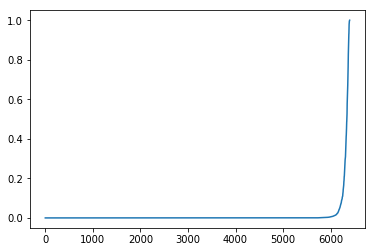

In [65]:
i = 12
x_test = np.expand_dims(patched_imgs[i], axis=0)

x_test = torch.from_numpy(x_test).type(torch.FloatTensor)

preds = big_cnn(Variable(x_test))

preds = preds.data.numpy()[:, 1]
print(preds.shape)

preds = np.squeeze(preds)

preds = np.reshape(preds, (80, 80))

#plt.figure(figsize=(10,10))
#plt.imshow(preds, cmap='Greys_r')

plt.plot(np.sort(np.ravel(preds)))

preds[preds <= 0] = -1
preds[preds > 0] = 1

#plt.plot(np.sort(np.ravel(preds)))
np.unique(preds)

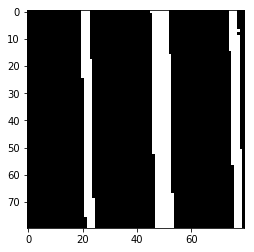

In [72]:
plt.imshow(patched_gts[i], cmap='Greys_r')

0.0260392 -1.0


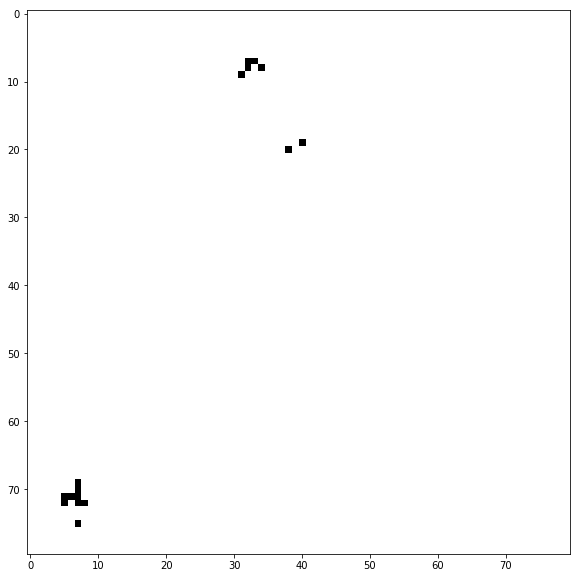

In [74]:
ori = drop_external_layers(patched_gts[i], 1)

plt.figure(figsize=(10,10))
print(np.min(patched_imgs[0]), np.min(preds))
plt.imshow(preds, cmap='Greys_r')

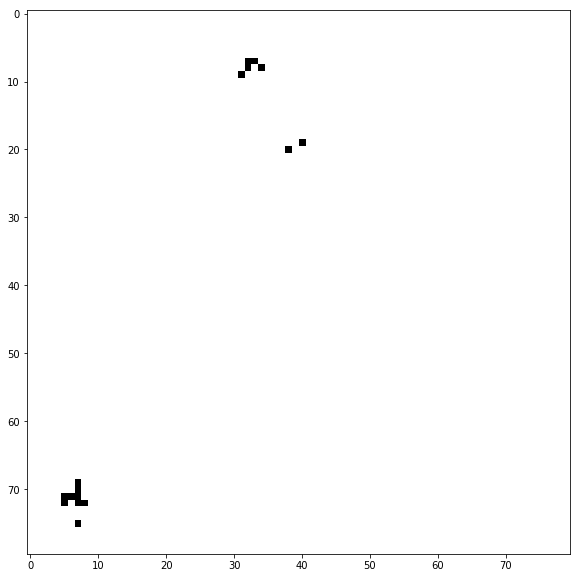

In [67]:
plt.figure(figsize=(10,10))
plt.imshow(preds, cmap='Greys_r')

In [68]:
from skimage.morphology import dilation, erosion, square, rectangle

In [ ]:
plt.figure(figsize=(10,50))
#im = erosion(dilation(preds))
res = preds
im = preds
for i in range(10):
    im = erosion(dilation(preds, square(i+3)), square(i+3))
    res = np.vstack([res , im])
    

plt.imshow(res, cmap='Greys_r')